# Active RL with Q-learning

We're looking at the case of Reinforcement Learning with partially observable rewards. The agent can query the reward function and there is an (e.g. fixed) cost of every query the agent makes. The agent knows the dynamics of the query operation, and can make decisions based on it.

There should be pricipled approaches to making these query decisions, possibly within the standard RL framework (e.g. based on planning incorporating the possible outcomes of the query), but we focus on heuristics for now.

------------------------------------------------------------------------------------------------------------
Now I'll go through the experiment script that I've been using.  It is self contained, besides a few imports.

In [1]:
from pylab import *
import scipy
# TODO: fix this import
#import scipy.stats
import numpy
np = numpy
from collections import OrderedDict
import time

Note that we use the global variables throughout.

In [2]:
# the current time-step, state, and action
step = 0
current_state = 0
current_action = 0


## Gridworld Environment

We ues an 8x8 gridworld for our experiments.


In [3]:
# states (lexical order)
grid_width = 8 
states = range(grid_width**2)
# actions: stay, N, E, S, W
actions = range(5)


# The rewards are sparse and stochastic (Bernoulli, with p drawn from U(0,1)).
prob_zero_reward = .9
reward_probabilities = np.random.binomial(1, 1 - prob_zero_reward, len(states)) * np.random.uniform(0, 1, len(states))

# The agent seeks to maximize reward over a life-time of 100000 time-steps.
num_steps = 100000

# There is some chance that the agent moves randomly, instead of as the action it chose dictates.
prob_random_move = 0.1 
# There are also poisson random resets bringing the agent back to the start state.
prob_random_reset = 0.001

In [4]:
# In practice, we use the same MDP for most experiments, so that we can do fair comparisons of different methods.
#reward_probabilities = np.load('/u/kruegerd/CS188.1x-Project3/fixed_mdp0.npy')
# Or we use a suite of random MDPs, in case the one above is biased against certain methods.
#reward_probabilities = np.load('/u/kruegerd/CS188.1x-Project3/200mdps.npy')

In [5]:
# basic environment dynamics.
# running into walls leaves you where you are.
def get_next_state(state, action):
    row, column = state / grid_width, state % grid_width
    if np.random.binomial(1, prob_random_move): # action is replaced at random
        action = np.argmax(np.random.multinomial(1, [.2,.2,.2,.2,.2]))
    if action == 1 and row > 0:
        next_state = state - grid_width
    elif action == 2 and column < grid_width - 1:
        next_state = state + 1
    elif action == 3 and row < grid_width - 1:
        next_state = state + grid_width
    elif action == 4 and column > 0:
        next_state = state - 1
    else:
        next_state = state
    return next_state

## Q-learning
We learn via Q-learning, keeping a table of Q-values.
Since we only get reward when we query it, we need a default value to replace the observed reward with, when we don't query.  Our solution is to maintain a beta distribution over the parameters of the reward function for every (s,a) pair and take the expectation of this distribution, although sampling could also be used.

In [6]:
Q_values = [[0,0,0,0,0] for state in states]

# for now, we use epsilon greedy
epsilon = 0.1
gamma = .9 # discount factor
learning_rate = .1

def update_q(state0, action, state1, reward, query):
    if not query:
        reward = expected_reward(state0, action)
    old = Q_values[state0][action]
    new = reward + gamma*np.max(Q_values[state1])
    Q_values[state0][action] = (1-learning_rate)*old + learning_rate*new

## Bayesian updating

To compute the expected reward, we need to keep track of our reward observations and queries
We can also use this information to maintain a distribution over states, which could allow us to prefer learning about commonly visited states.


In [7]:
# track the number of times each (s,a) has been visited/queried, and the amount of rewards observed. 
num_visits = [[0,0,0,0,0] for state in states]
num_queries = [[0,0,0,0,0] for state in states]
observed_rewards = [[0,0,0,0,0] for state in states] 


# We learn a beta-bernoulli distribution over the reward function of each (s,a)
# we use a lookup table to speed up computation
beta_entropy_lookup = {}

def reward_entropy(state, action):
    # alpha_, beta_ are the empirical counts
    alpha_ = observed_rewards[state][action]
    beta_ = num_queries[state][action] - alpha_
    if (alpha_, beta_) in beta_entropy_lookup:
        entry = beta_entropy_lookup[(alpha_, beta_)]
    else:
        # we use Jeffrey's prior (adding .5 to get pseudo-counts)
        entry = scipy.stats.beta(alpha_ + .5, beta_ + .5).entropy()
        beta_entropy_lookup[(alpha_, beta_)] = entry
    return entry

def expected_reward(state, action):
    alpha = observed_rewards[state][action] + .5
    beta = ( num_queries[state][action] + 1) - alpha
    return alpha / (alpha + beta)


# learn a distribution over states (dirichlet-multinomial) 
def state_entropy():
    return scipy.stats.dirichlet([sum(nvisit) + .5 for nvisit in nvisits]).entropy()
def state_probability(state):
    (sum(nvisits[state]) + .5) / (step + .5*len(states))


## Active Learning and Query Functions
We use simple heuristics to decide when to query the reward.
A more principled approach should work better.


In [8]:
query_cost = 100.

# Query functions
query_functions = OrderedDict()

# simple baselines
query_functions['every time'] = lambda : True

# we set the query budget to target a maximum total query cost.
budget = 'low'
if budget == 'high':
    max_num_queries = 300000. / query_cost
elif budget == 'med':
    max_num_queries = 10000. / query_cost
elif budget == 'low':
    max_num_queries = 3000. / query_cost
elif budget == 'very_low':
    max_num_queries = 1000. / query_cost

query_functions['first N steps'] = lambda : step < max_num_queries
# in practice these end up making ~90% and 50% as many queries as the above:
query_functions['first N state visits'] = lambda : sum(num_visits[current_state]) < (max_num_queries / len(states))
query_functions['first N (state,action) visits'] = lambda : num_visits[current_state][current_action] < (max_num_queries / (len(states) * len(actions)))

query_probability_decay = 1 - 1. / max_num_queries 
query_functions['decaying probability'] = lambda : np.random.binomial(1, query_probability_decay**step)

#---------------------------------
# Some more complicated heuristics

# query based on entropy of P(r|s,a):
query_functions['r entropy threshold'] = lambda : reward_entropy(current_state, current_action) > -1
query_functions['stochastic r entropy'] = lambda : np.random.binomial(1, np.exp(reward_entropy(current_state, current_action)))

# query (s,a) with probability proportional to its share of the sum of expected rewards across all (s,a) pairs.
query_functions['proportion of expected reward'] = lambda : np.random.binomial(1, expected_reward(current_state, current_action) / sum(expected_reward(s,a) for s in states for a in actions))

# query based on number of state visits:
query_functions['prob = proportion of state visits'] = lambda : np.random.binomial(1, (sum(nvisits[current_state]) + 50) / (sum(nvisits) + 50. * len(states)))
query_functions['prob = proportion of state-action visits'] = lambda : np.random.binomial(1, (sum(nvisits[current_state][action]) + 10) / (sum(nvisits) + 10. * len(states) * len(actions)))


# query based on entropy of softmax policy (N.B. we don't actually use that policy):
def multinomial_entropy(probs): # TODO: stability?
    return -np.sum(probs * np.log(probs))

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def softmax_entropy(state, action):
    return multinomial_entropy(softmax(Q_values[state]))

query_functions['softmax entropy threshold'] = lambda : softmax_entropy(current_state, current_action) > 1


## Running the environment
In this loop, we put it all together, and see how our agent and query function perform in this environment

In [9]:
query_function = query_functions['first N (state,action) visits']
query_function = query_functions['proportion of expected reward']


t1 = time.time()

total_reward = 0

for step in range(num_steps):
    current_action = np.argmax(Q_values[current_state])
    if np.random.binomial(1, epsilon): # take a random action
        current_action = np.argmax(np.random.multinomial(1, [.2, .2, .2, .2, .2]))
    num_visits[current_state][current_action] += 1
    reward = np.random.binomial(1, reward_probabilities[current_state])
    total_reward += reward 
    query = query_function()
    if query:
        num_queries[current_state][current_action] += 1
        observed_rewards[current_state][current_action] += reward

    old_state = current_state
    current_state = get_next_state(current_state, current_action)
    
    if np.random.binomial(1, prob_random_reset): # reset to initial state
        current_state = 0

    # perform q-learning 
    update_q(old_state, current_action, current_state, reward, query)

total_observed_rewards = sum([ sum(r_observed) for r_observed in observed_rewards])
total_num_queries = sum([ sum(num_queries) for num_queries in num_queries])
total_query_cost = query_cost * total_num_queries
performance = total_reward - total_query_cost

print "total_reward =", total_reward
print "total_observed_reward =", total_observed_rewards
print "total_num_queries =", total_num_queries
print "performance =", performance
print time.time() - t1

total_reward = 45253
total_observed_reward = 218
total_num_queries = 386
performance = 6653.0
43.8960540295


# Results
The results can be very noisy.  To measure the performance of different algorithms, we may need to run 100s of experiments.

We also need to see the effect of different hyper-parameters, such as the cost of queries, and hyper-parameters of the query functions.

So far, we don't have any conclusive results comparing all the different query functions, due to bugs.


We've compared:

1) the "query the first N times visiting a (state, action) pair" heuristic.

2) a heuristic which is more likely to query (state, action) pairs with higher expected reward.


We look at the average performance over 100 experiments for each combination of query function and query cost.  There's some interaction between the query cost and the best query budget: it looks like the budget should be increased for larger costs, which makes sense (up to a point), since learning enough to act appropriately is very valuable, and presumably requires roughly K queries for some threshold K.  For large enough query costs (and short enough horizons), however, seeking information about rewards ceases to have positive expected value.

## Figures
These figures compare the performance of 1 and 2, for different values of N.

Heuristic 2 is always in the middle.

Heuristic 1 goes from more to less queries (going left to right).


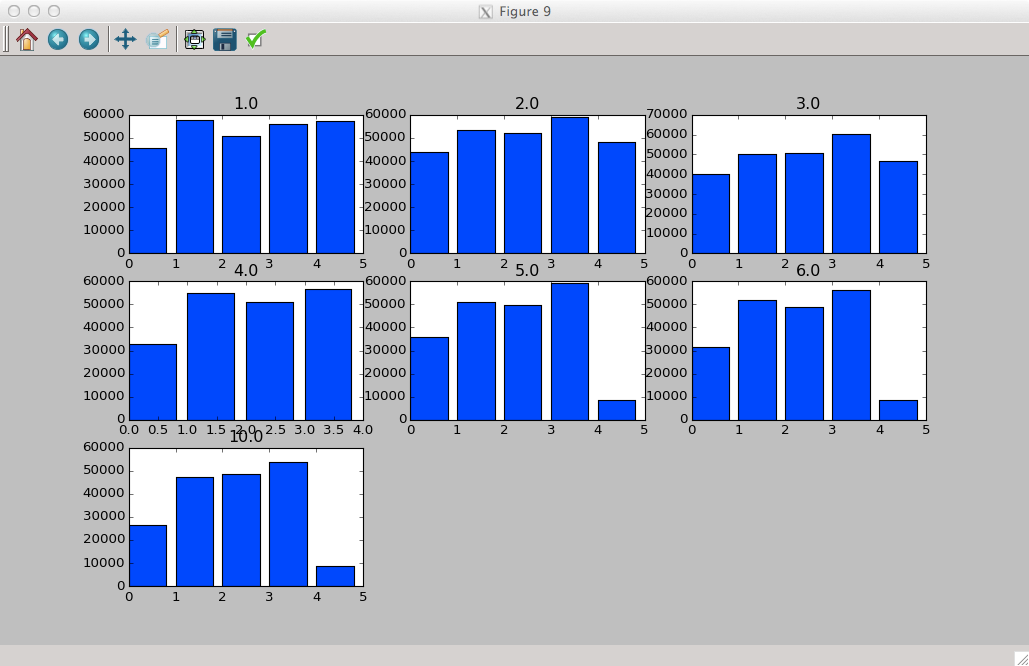

In [15]:
from IPython.display import Image
Image(filename='1_10.png')